In [1]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
MODEL_PATH = "zimfoodkidney.h5"
CLASS_NAMES_PATH = "class_names.json"

model = tf.keras.models.load_model(MODEL_PATH)

with open(CLASS_NAMES_PATH, "r") as f:
    class_names = json.load(f)

print("Model loaded successfully")
print("Classes:", class_names)


Model loaded successfully
Classes: ['apple', 'bambaranuts', 'banana', 'beefstew', 'cabbage', 'chicken', 'corn', 'eggs', 'grapes', 'kapenta', 'mango', 'onion', 'orange', 'peas', 'potato', 'rape', 'rice', 'sadza(maize_meal)', 'soy beans', 'sweetpotato', 'tomato']


In [3]:
TEST_DIR = "data/local_food_dataset/test"

test_set = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)

# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_set = test_set.map(lambda x, y: (normalization_layer(x), y))

print("Test dataset loaded")


Found 197 files belonging to 20 classes.
Test dataset loaded


In [5]:
from tensorflow.keras.preprocessing import image

def predict_food(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    predicted_food = class_names[predicted_index]

    return predicted_food, confidence


1/1 [==============================] - 0s 274ms/step


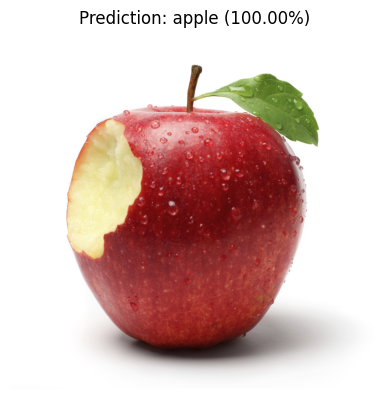

In [6]:
sample_image_path = os.path.join(
    TEST_DIR,
    class_names[0],
    os.listdir(os.path.join(TEST_DIR, class_names[0]))[0]
)

food, confidence = predict_food(sample_image_path)

plt.imshow(plt.imread(sample_image_path))
plt.axis("off")
plt.title(f"Prediction: {food} ({confidence:.2%})")
plt.show()


In [7]:
for food_name in class_names[:5]:
    folder = os.path.join(TEST_DIR, food_name)
    img_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, img_file)

    pred, conf = predict_food(img_path)
    print(f"Actual: {food_name} → Predicted: {pred} ({conf:.2%})")


1/1 [==============================] - 0s 66ms/step
Actual: apple → Predicted: apple (100.00%)
1/1 [==============================] - 0s 62ms/step
Actual: bambaranuts → Predicted: bambaranuts (99.92%)
1/1 [==============================] - 0s 37ms/step
Actual: banana → Predicted: banana (100.00%)
1/1 [==============================] - 0s 31ms/step
Actual: beefstew → Predicted: beefstew (99.99%)
1/1 [==============================] - 0s 58ms/step
Actual: cabbage → Predicted: cabbage (99.76%)


#After CNN predicts a food name ,we want to : food name -> potassium -> phosphorus->sodium ->kidney_friendly verdict

#Load nutrient data from csv

In [9]:
import pandas as pd

# Load nutrient data
nutrients_df = pd.read_csv("nutrients.csv")

# Inspect first few rows to confirm
nutrients_df.head()


,food,potassium_mg,phosphorus_mg,sodium_mg
0,apple,107,11,1
1,banana,358,22,1
2,grapes,191,20,2
3,orange,181,14,0
4,mango,168,14,2


In [10]:
def get_nutrients(food_name):
    row = nutrients_df[nutrients_df["food"] == food_name]

    if row.empty:
        return None

    return {
        "potassium": int(row["potassium_mg"].values[0]),
        "phosphorus": int(row["phosphorus_mg"].values[0]),
        "sodium": int(row["sodium_mg"].values[0])
    }


In [11]:
def kidney_friendly(nutrients):
    potassium = nutrients["potassium"]
    phosphorus = nutrients["phosphorus"]
    sodium = nutrients["sodium"]

    issues = []

    if potassium > 300:
        issues.append("High potassium")
    if phosphorus > 200:
        issues.append("High phosphorus")
    if sodium > 200:
        issues.append("High sodium")

    if issues:
        return "❌ Not kidney friendly", issues
    else:
        return "✅ Kidney friendly", []


In [12]:
image_path = sample_image_path  # reuse earlier image

food, confidence = predict_food(image_path)
nutrients = get_nutrients(food)

status, reasons = kidney_friendly(nutrients)

print(f"Food: {food}")
print(f"Confidence: {confidence:.2%}")
print("Nutrients (mg/100g):", nutrients)
print("Verdict:", status)

if reasons:
    print("Reasons:", ", ".join(reasons))


1/1 [==============================] - 0s 62ms/step
Food: apple
Confidence: 100.00%
Nutrients (mg/100g): {'potassium': 107, 'phosphorus': 11, 'sodium': 1}
Verdict: ✅ Kidney friendly
